# Złożoność i wybór modelu

<h1 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [40]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing

In [4]:
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression, make_s_curve
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.cross_validation import cross_val_predict, KFold, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, mean_squared_error

In [5]:
from astroML.datasets import fetch_imaging_sample
from sklearn.preprocessing import PolynomialFeatures
from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

# Błąd testujący i bład uczenia

* __Generalizacja__ określa jak dobrze model będzie sobie radził na danych, których __nie__ widział w trakcie uczenia
  * potrzebujemy metod, które
    1. określać jakość modeli
    * porównywać modele
    * wybierać najlepszy model dla zadanego problemu
      * to dotyczy zarówno typu modelu jak i wyboru parametrów
    * oceniać końcowy błąd wybranego modelu
    * oceniać złożoność modelu
    
    
* __funkcja kosztu__ (__loss function__) jest miarą błędu jaki model popełnia, na przykład funkcja kwadratowa $$L(Y, \hat{f}(X)) = (Y-\hat{f}(X))^2$$
* funkcja $\hat{f}$ została nauczona na danych __trenujących__
  * funkcja kwadratowa jest szeroko używana w zadaniu regresji, ale są dla niego także inne wybory
  * dla klasyfikacji jest wiele innych opcji
  
  
* błąd __testujący__ (albo __generalizacji__) to błąd predykcji (regresji) modelu (nauczonego na zbiorze $\mathcal{T}$) na __ustalonej niależnej__ próbce danych $$Err_\mathcal{T}=E[L(Y, \hat{f}(X))|\mathcal{T}]]$$
* __oczekiwany błąd predykcji__ to $$Err=E[L(Y, \hat{f}(X))]=E[Err_\mathcal{T}]$$
  * to wartość oczekiwana po wszelkich zbiorach uczących (a wobec tego po wszelkich $\hat{f}$) i zbiorach testujących
  * będziemy potrzebowali odpowiedniej procedury by estymować $Err$ i wybrać minimalizujący go model
* błąd __uczenia__ to średni koszt dla zbioru czącego $$err=\frac{1}{N}\sum_i L(Y, \hat{f}(X))$$
  * błąd trenujący __nie jest__ dobrym przybliżeniem błędu predykcji!
  
  
* podobnie dla innych rodzajów błędów
  
   

* typowym problemem jest __brak danych__
  * jesli danych jest bardzo dużo, to można rozdzielić dane na 
    1. __uczące__: dla nauczania
    * __walidujące__: dla wyboru optymalnych parametrów
    * __testujące__: dla sprawdzania błędu generalizacji

## Podział błędu na odchylenie i wariancję (bias-variance decomposition)

* dane pochodzą z procesu pomiaru, są wobec tego obarczone __nieusuwalnym błędem__ $\epsilon$ $$y_i=f(x_i)+\epsilon$$
  * prawdziwa (true) funkcja $f$ jest nieznana
  * o błędzie można założyć, że $E[\epsilon]=0$ oraz $E[\epsilon^2]=\sigma^2$
  
  
* zakładamy, że $L()$ jest __kwadratowa__
$$\begin{align}
Err(x)&=E[L(Y, \hat{f}(X))|X=x]=E[(y-\hat{f}(x))^2]\\
&=E[(f(x)+\epsilon-\hat{f}(x))^2]=E[(f(x)-\hat{f}(x)+\epsilon)^2]\\
&=E[(f(x)-\hat{f}(x))^2]+E[2\epsilon(f(x)-\hat{f}(x))]+E[\epsilon^2]&\text{błąd $\epsilon$ jest nieskorelowany z błędem predykcji}\\
&=E[(f(x)-\hat{f}(x))^2]+E[\epsilon^2]\\
\\
&=E\left[\left(f(x)-E[\hat{f}(x)]+E[\hat{f}(x)]-\hat{f}(x)\right)^2\right]+E\left[\epsilon^2\right]\\
\\
&=E\left[\left(f(x)-E[\hat{f}(x)]\right)^2\right]\\
&+E\left[\left(f(x)-E[\hat{f}(x)]\right)\left(E[\hat{f}(x)]-\hat{f}(x)\right)\right]&\text{błedy są znowu nieskorelowane}\\
&+E\left[\left(E[\hat{f}(x)]-\hat{f}(x)\right)^2\right]+E\left[\epsilon^2\right]\\
\\
&=\underbrace{E\left[\left(f(x)-E[\hat{f}(x)]\right)^2\right]}_{\text{bias}^2}
+\underbrace{E\left[\left(E[\hat{f}(x)]-\hat{f}(x)\right)^2\right]}_{\text{wariancja modelu}}
+\underbrace{E\left[\epsilon^2\right]}_{\text{szum danych}}
\end{align}$$

* __bias$^2$__: to suma kwadratów różnic między wartością prawdziwej (ale nieznanej) funkcji $f()$ a wartością oczekiwaną estymacji,
* __wariancja modelu__: (czasem __błąd estymacji__) używając różnych zbiorów uczących, różnych parametrów modelu, różnych punktów startu (w algorytmach iteracyjnych) możemy dostać różne dofitowania modelu, a stąd modele będą miały pewną wariancję wokół wartości średniej
* __szum danych__: jest niezależny od procesu uczenia; zwykle jest to biały szum



* rozkład błędu pozwala na wyciągnięcie wniosków o uczeniu
  * oczekujemy, że model bedzie __maksymalnie prosty__
    * wtedy jednak możliwy jest wysoki bias, gdy model jest __prostszy__ od rzeczywistych danych (estymacja wielomiany prostą)
    * bias można zredukować przez zwiększenie przestrzeni dostępnych funkcji
    * modele w których bias przeważa często "__underfitują__"
      * zwykle na początku uczenia model jest zwykle bardzo prosty, ma duzy błąd a bias przeważa nad wariancję
      * proste modele: wysoki bias i niska wariancja
  * jednocześnie chcemy, by model dobrze się __dostosowywał__
    * wtedy może mieć wysoką wariancję
      * podczas procesu uczenia  model coraz lepiej dostosowuje się, bias i błąd spadają
      * błąd dla zbioru trenującego stale maleje
      * jednak wariancja (dla różnych modeli) zaczyna wzrastać i nie ma pewności czy model bedzie dobrze generalizował
      * modele z przewagą wariancji często "__przefitowują__"
      * modele z ograniczoną przestrzenią funkcji (np. ridge, lasso) dają niską wariancję
      * złożony model: niski bias i wysoka wariancja
  * rozwiązania?
    * uczenie należy przerwać wcześniej nim osiągnie minimalny błąd
      * metoda wczesnego zatrzymywania (early stopping)
      * kontrola za pomocą zbioru walidacyjnego
      * metoda walidacji krzyżowej
    



* analogiczne rozumowanie dla innych funkcji kosztu nie jest oczywiste
  * Domingos zaproponował ostatnio rozwinięcie do zero-jedynkowej funkcji kosztu

In [6]:
from itertools import combinations

In [7]:
def bootstrap_linear_approximations(models=10, n_samples=100, noise=0.5):
    X = np.random.uniform(-5, +5, [n_samples, 1])
    #X = np.linspace(-5, 5, 100).reshape((100, 1))
    t0 = 0.25; t1 = 0.02; t2 = 0.04; t3 = 0.04
    y_true =  (0.25 + t1 * X + t2 * X**2 + t3 * X**3).reshape((n_samples,))
    if noise > 0.:
        y = y_true + np.random.normal(scale=noise, size=len(y_true))
    else:
        y = y_true
    #print 'X.shape = {}, y_true.shape = {}, y.shape = {}'.format(X.shape, y_true.shape, y.shape)
    #print X
    #print y_true
    #print y
    y_noise = np.sum((y - y_true) ** 2) / n_samples
    
    fig, ax = plt.subplots(figsize=(18, 8))
    xmin, xmax = min(X), max(X)
    ymin, ymax = min(y), max(y)
    x_range = np.linspace(xmin, xmax, 100)
    ax.plot(X, y, 'r*')
    ax.plot(X, y_true, 'g*')
    ax.grid()
    #ax.plot(x_range, x_range * theta_data[1] + theta_data[0], 'k-')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    theta = np.zeros((models, 2))
    predicted_all = np.zeros((models, len(y)))
    #print np.mean(y)
    print '\tnoise\t  variance\t  bias\t\t  mse\n{}'.format('-' * 70)
    for k in range(models):
        X_train, y_train = resample(X, y)
        clr = LinearRegression()
        clr.fit(X_train, y_train)
        predicted = clr.predict(X)
        predicted_all[k, :] = predicted
        theta_fit = [np.mean(predicted), clr.coef_]
        ax.plot(x_range, x_range * theta_fit[1] + theta_fit[0], lw=1)
        theta[k, :] = theta_fit
        y_fit_mean = np.mean(predicted)
        var = np.sum((y - y_fit_mean) ** 2) / n_samples
        bias_squared = np.sum((y_true - y_fit_mean) ** 2) / n_samples
        mse = y_noise + var + bias_squared
        err = np.sum((y - predicted) ** 2) / n_samples
        #print '{}: \t{}\t+ {}\t+ {}\t= {}'.format(k, np.round(y_noise, 4), np.round(var, 4), 
        #                                             np.round(bias_squared, 4), np.round(mse, 4))
        
    theta_mean = np.mean(theta, 0)
    ax.plot(x_range, x_range * theta_mean[1] + theta_mean[0], 'k-', lw=5)
    # teraz licze oczekiwana wartosc obliczonej funkcji
    y_ens_fit = np.mean(predicted_all, 0)
    y_ens_fit_mean = np.mean(y_ens_fit)
    var = 0
    for m in range(models):
        var = np.sum((y_ens_fit - predicted_all[m, ]) ** 2)
    var /=  models * n_samples ** 2
    # var = np.sum((y_ens_fit - y_ens_fit_mean) ** 2) / (n_samples ** 2)
    bias_squared = np.sum((y_true - y_ens_fit) ** 2) / n_samples
    mse = y_noise + var + bias_squared
    err = np.sum((y_true - y_ens_fit) ** 2) / n_samples
    print '{}: \t{}\t+ {}\t+ {}\t= {}'.format('ens', np.round(y_noise, 4), np.round(var, 4), 
                                                  np.round(bias_squared, 4), np.round(mse, 4))
    
    compute_ensembles = True
    if compute_ensembles:
        max_models = 100
        for k in range(1, models):
            comb = [c for c in combinations(range(models), k)]
            # select max_models indices
            ind = list(np.random.choice(len(comb), max(max_models, len(comb))))
            var_ens = 0
            bias_squared_ens = 0
            mse_ens = 0
            for q in ind:
                p = comb[q]
                y_ens_fit = np.mean(predicted_all[p, ], 0)
                y_ens_fit_mean = np.mean(y_ens_fit)
                var = 0
                for m in p:
                    var = np.sum((y_ens_fit - predicted_all[m, ]) ** 2)
                var /=  len(p) * n_samples ** 2
                var_ens += var / len(p)
                bias_squared = np.sum((y_true - y_ens_fit) ** 2) / n_samples
                bias_squared_ens += bias_squared / len(p)
            var_ens /= len(ind)
            bias_squared_ens /= len(ind)
            mse = y_noise + var_ens + bias_squared_ens
            print '{}:{}: \t{}\t+ {}\t+ {}\t= {}'.format('e', k, np.round(y_noise, 4), np.round(var_ens, 4), 
                                                              np.round(bias_squared_ens, 4), np.round(mse, 4))
    

	noise	  variance	  bias		  mse
----------------------------------------------------------------------
ens: 	1.7515	+ 0.0004	+ 0.6711	= 2.4229
e:1: 	1.7515	+ 0.0	+ 0.7358	= 2.4873
e:2: 	1.7515	+ 0.0002	+ 0.3483	= 2.1
e:3: 	1.7515	+ 0.0002	+ 0.2295	= 1.9812
e:4: 	1.7515	+ 0.0001	+ 0.1715	= 1.9231
e:5: 	1.7515	+ 0.0001	+ 0.1363	= 1.8878
e:6: 	1.7515	+ 0.0001	+ 0.1128	= 1.8643
e:7: 	1.7515	+ 0.0001	+ 0.0966	= 1.8481
e:8: 	1.7515	+ 0.0001	+ 0.0841	= 1.8356
e:9: 	1.7515	+ 0.0	+ 0.0748	= 1.8264


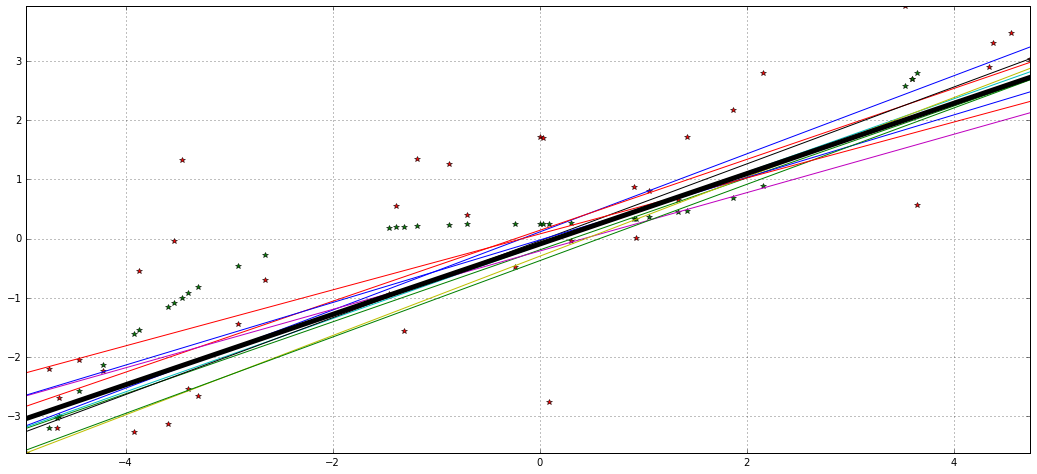

In [8]:
bootstrap_linear_approximations(models=10, n_samples=40, noise=1.5)

### Bias-wariancja dla modelu k-najbliższych sąsiadów
$$\begin{align}
Err(x)&=\underbrace{E\left[\left(f(x)-E[\hat{f}(x)]\right)^2\right]}_{\text{bias}^2}
+\underbrace{E\left[\left(E[\hat{f}(x)]-\hat{f}(x)\right)^2\right]}_{\text{wariancja modelu}}
+\underbrace{E\left[\epsilon^2\right]}_{\text{szum danych}}
\end{align}$$


* Dla k-najbliższych sąsiadów
$$ 
Err(x_0)=\underbrace{\left[f(x_0)-\frac{1}{k}\sum_{p=1}^k{f}(x_{(p)})\right]^2}_{\text{bias}^2}
+\underbrace{\frac{\sigma_{\epsilon}^2}{k}}_{\text{wariancja modelu}}
+\underbrace{\sigma^2}_{\text{szum danych}}
$$
  * przykłady uczące $x$ są ustalone
  * złożoność modelu jest w odwrotnej relacji do liczby sąsiadów _k_
  * wraz ze wzrostem _k_ kwadrat różnicy między prawdziwą wartością $f(x_0)$ a średnią z najbliższych sąsiadów __rośnie__ (czyli rośnie bias) a wariancja maleje

<img src="bias_variance_decomposition.png" width="100%"/> [rysunek: Hastie et al.]

<img src="bias_variance_tradeoff.png" width="90%" /> [rysunek: Hastie et al.]
* bias (zielony), wariancja niebieski), całkowity błąd (pomarańczowy)
* w problemach regresji (górny wiersz) bias i wariancja dodają się dając całkowity błąd
* w problemach klasyfikacji
  * bias i wariancja są takie same jak w problemach regresji
  * błąd predykcji __nie jest__ już sumą wariancji i biasu
    * niech prawdopodobieństwo danej klasy wynosi $0.85$ a wartość estymacji $0.55$
    * wartość biasu $(0.85-0.55)^2$ ma jednak w dalszym ciągu dużą wartość
    * predykcja jest jednak prawidłowa i błąd predykcji jest zerowy!
* rozwiązania dla problemów regresji i predykcji są dramatycznie różne!

# Wybór (selection) i ocena (assessment) modelu
* problem braku danych
* podział danych
* ocena modelu niemożliwa na danych uczących

## Walidacja krzyżowa

* danych zwykle brakuje, w przeciwnym wypadku można łatwo podzielić na zbiory __uczący__, __walidujący__ i __testujący__
* jak wykorzystać wszystkie dane do uczenia pozostawiając sobie dane do testowania???



* __walidacja krzyżowa__
  * podzielić zbiór danych na __K__ części
    * zwykle K = 3, 5, 10
    * podział powinien być losowy
    * dla problemów klasyfikacji często wykorzystywana __stratyfikacja__
  * powtórzyć K-krotnie 
    * nauczyć model na $K-1$ częściach
    * ocenić rozwiązanie na pozostałej części
  * końcowy błąd walidacji krzyżowej
  $$\boxed{CV(\hat{f})=\frac{1}{N}\sum_{i=1}^NL(y_i, \hat{f}^{-k(i)}(x_i))\;}$$
  gdzie $\hat{f}^{-k(i)}(x_i))$ jest wartością dla tego modelu, w którym przykład $x_i$ __nie był__przykładem uczącym
  * dla $K=N$ jest to metoda __leave_one_out__
    * ta estymacja ma dużą wariancję ze względu na podobieństwo przykładów       
    * kosztowne obliczeniowo
  * dla niskiego K wariancja będzie niska
    * problemem będzie wysoki bias modeli
    * niskie K powoduje zwykle przecenianie błędu generalizacji
    * wysokie K daje wysoką wariancję
    
    
  * K=10 wydaje się dobrym rozwiązaniem
    
      

### Problemy z walidacją krzyżową
* potrzebujemy zbudować najlepszy model dla zrównoważonego problemu klasyfikacji
  
  
1. podejście pierwsze (za Hastie et al.)
  1. dla całego zbioru wybieramy podzbiór zmiennych niezależnych o najwyższej korelacj z wyjściowymi etykietami
  2. używając tych zmiennych budujemy klasyfikator
  3, korzystając z walidacji krzyżowej określamy parametry i oceniamy model
2. podejście drugie
  1. podział danych na K foldów
  2. dla każdych K-1 foldów wybieramy zmienne niezależne o najwyższej korelacji ze zmienną zależną dla tych K-1 foldów
  3. budujemy klasyfikator z tych zmiennych dla przykładów z tych K-1 foldów
  4. oceniamy predykcję na pozostałym K-tym foldzie
  
  
* które podejścoie jest prawidłowe?
* co jest niepoprawne w drugim podejściu?

* K-ty fold musi być odłożony __przed__ jakimikolwiek operacjami w sposób __niezwiązany__ z etykietami
* ten błąd jest popełniany bardzo często w artykułach naukowych
  * autorzy często, czasem nieświadomie, dokonuje wstępnej selekcji cech i przykładów co wpływa na wyniki!

## Bootstrap
* bootstrap to uogólnienie walidacji krzyżowej


* procedura bootstrap
  1. B-krotnie wylosować __z powtórzeniami__ próbkę uczącą $Z=\{(x_i,y_i)\}$
    * zwykle B=100
  2. model jest uczony ponownie dla zbioru Z
  3. z tego można obliczyć estymację oczekiwanego błędu generalizacji
  $$\widehat{Err}=\frac{1}{B}\frac{1}{N}\sum_{b=1}^B\sum_{i=1}^NL(y_i, \hat{f}^{*b}(x_i)),$$ gdzie $\hat{f}^{*b}(x_i)$ jest wartością modelu dla b-tego zbioru bootstrap dla $x_i$
  
* taka procedura jest zbyt optymistyczna
  * zbiory uczący i testujące przecinają się i predykcje nadmiernie dopasowują się (overfitting)
  * jakie jest prawdopodobieństwo, że i-ta obserwacja będzie w b-tym zbiorze bootstrap? 
  $$\begin{align}P(i; b)&=1-P(-i;b)=1-\left(1-\frac{1}{N}\right)^N\\
  &\approx 1-e^{-1}\approx0.632\end{align}$$
  * stąd wartość oczekiwana (dla binarnego problemu) $E[\widehat{Err}]=0.5\times(1-0.632)=0.184$
    * to znacznie bardziej optymistyczna wartość niż oczekiwane $0.5$!
  * bootstrap powinno działac tak, jak walidacja krzyżowa!
    * z każdym przykładem zachowujemy listę indeksów $C^{-i}$ zbiorów bootstrap b w których przykład i-ty __nie__ występował
    $$\boxed{
    \widehat{Err}^{(1)}=\frac{1}{N}\sum_{i=1}^N\frac{1}{|C^{-i}|}\sum_{b\in C^{-i}}L(y_i, \hat{f}^{*b}(x_i))
    \;}$$
      * B powinno być na tyle duże, by każdy przykład chociaż raz __nie__ występował w zbiorze uczącym
  * liczba różnych przykładów w każdym zbiorze bootstrap jest rzędu $0.632N$
    * stąd zbiór jest "mały" w stosunku do całego i może mieć duży bias
    * będzie przypominać walidację krzyżową z dwoma foldami i pesymistycznym błędem
    * poprawka statystyczna
    $$\boxed{
    \widehat{Err}^{(0.632)}=0.368\times\overline{err}+0.632\times \widehat{Err}^{(1)}
    ,\;}$$
      * gdzie $\overline{err}$ jest błędem na zbiorze trenującym
      * działa czasem źle w sytuacjach nadmiernego dopasowania
      * istnieją dodatkowe rozszerzenia bootstrap
* bootstrap bywa kosztowne obliczeniowo ze względu na dużą liczbę modeli do znalezienia
  * jednak estymacja oczekiwanej predykcji jest lepsza niż ta walidacji krzyżowej

# A jak znaleźć najlepszy model?


* mamy zbiór modeli z danej rodziny
* dostępny jest także zestaw zbiorów uczących z pewnej rodziny, np. zastosowania
* zmienne są architektura modeli, parametry i ich liczba
* potrzebujemy określić jak algorytmy z tej rodziny radzą sobie z zadanymi problemami



1. podziel zbiór uczący na K foldów
2. for k=1,...,K
  1. podziel K-1 foldów poza k-tym na P foldów
  2. for p=1,...,P
     1. naucz każdy z ustalonych modeli (architektury, układy parametrów, funkcje bazowe, etc.) na P-1 foldach poza p-tym
     2. oceń każdy model na p-tym foldzie
   3. wybierz najlepszy model (z najlepszą statystyką CV) (lub kilka)
   4. oceń wybrany model n k-tym foldzie
3. wylicz końcowe statystyki walidacji krzyżowej



* procedura kosztowna i czasochlonna

# Ocena jakości modelu

* po uczeniu potrzebujemy określić jego __jakość__ na ile dobrze będzie on minimalizował popełniane błędy
  * w trakcie uczenia minimalizowana jest __funkcja celu__ przyjęta na początku: kwadratowa, entropii krzyżowej, etc
  * później jednak potrzebna jest inna (niekoniecznie jedyna) miara __dobroci__ modelu
  * ta funkcja ocenia jak dobrze przybliżane są przykłady ze zbioru danych (czące czy testujące), niekoniecznie jest to bezpośrednia wartość funkicji celu
  * __minimalizacja danej funkcji celu _niekoniecznie_ minimalizuje także inną funkcję jakości__
      

## Funkcje oceniające (score functions) dla problemów regresji
* __średni błąd kwadratowy__ $$MSE(y, \hat{y})=\frac{1}{N}\sum_{i=1}^N(y_i-\hat{y}_i)^2$$
  * MSE może przyjmować dowolne (dodatnie) wartości; jest bezpośrednio minimalizowana przez model używający kwadratowej funkcji kosztu
  * tzw. __outliers__ mają duży wpływ na jej wartość
  
  
  
* __średni błąd bezwzględny__ $$MAE(y, \hat{y})=\frac{1}{N}\sum_{i=1}^N|y_i-\hat{y}_i|$$
  * bezpośrednio minimalizowany przez sieci z funkcją kosztu $\ell_1$
    * rzadziej wykorzystywane ze względu na nieciągłość pochodnej $\ell_1$
      * zwykle obsługiwane programistycznie
  * redukuje wpływ outliers  
  
  
* __bezwzględny błąd mediany__ $$MedAE(y,\hat{y})=median(\{|y_i-\hat{y}_i|\}_{i=1}^N)$$
  * szczególnie odporny na outliers
   
   
* __miara $R^2$__ $$R^2(y,\hat{y})=1-\frac{\sum_i(y_i-\hat{y}_i)^2}{\sum_i(y_i-\overline{y})^2},$$
gdzie $\overline{y}_i$ jest __średnią__ prawdziwych wyjsciowych wartości
  * $R^2$ odpowiada __współczynnikowi uwarunkowania__
  * ocenia na ile dobrze przyszłe przykłady będą przybliżane
  * model przybliżający idalnie ma wartość $R^2=1$
  * model zwracający zawsze wartość oczekiwaną ma $R^2=0$
    * ten model __nie zwraca__ uwagi na atrybuty wejściowe
  * modele jeszcze słabsze mogą mieć wartości %R^2$ ujemne
  * $R^2$ pozwala częściowo porównywać różne modele, także na różncy danych, co jest trudne dla regresji
  
  
* __miara tłumacząca przez wariancję__ $$ev(y,\hat{y})=1-\frac{var\{y-\hat{y}\}}{var\{y\}}$$
  * najlepszy model ma wartość $1.0$

## Funkcje oceniające dla problemów klasyfikacji
* __accuracy__ $$acc(y,\hat{y})=\frac{1}{N}\sum_i1(\hat{y}_i=y_i)$$
  * właściwie ułamek przykładów poprawnie zaklasyfikowanych, stąd $acc\in[0,1]$
  * odpowiada zero-jedynkowej funkcji kosztu
  * podobnie __miara Hamminga__ zwraca frakcję źle przewidzianych etykiet
  * __miara Jaccarda__ zwraca frakcję identycznie etykietowanych przez liczność etykiet
  
  
* __macierz pomyłek (_confusion matrix_)__
  * macierz $K\times K$ opisująca błędne przypisania przykładów z prawdziwej klasy $i$ do innej (nieprawdziwej) klasy $j$
  * macierz idealna jest przekątniowa
  * elementy macierzy mgą być liczbą bądź frakcją przypisań
  * pozwala na analizę działąnia algorytmu
    * jeśli liczności klas są niezrównoważone, to bardziej ogólne miary ukrywają to, a macierz pomyłek pozwala znaleźć specyficzne zachowania
    
    


* __entropia krzyżowa__ $$H(y,\hat{y})=-\sum_iy_i\ln(\hat{y}_i)+(1-y_i)\ln(1-\hat{y}_i)$$
  * zwane też __log loss__ (logarytm __naturalny__)
  * dla $N$ przykładów i $K$ klas entropia krzyżowa bedzie miała postać $$H(y,\hat{y})=-\frac{1}{N}\sum_i^N\sum_k^Ky_{ik}log\hat{y}_{ik}$$
  * $\hat{y}_i$ jest estymowanym prawdopodobieństwem, że $y_i=1$
  * bezpośrednio minimalizowalna funkcja kosztu
  <img src="entropy000.png"/>  <img src="entropy001.png"/> [Rys. z scikit-learn.org]
  
  
  
* __hinge loss__ $$L_{hinge}(y,\hat{y})=\max\{1-y\hat{y}, 0\}$$

## Pojęcia false positives, false negatives i pochodne
* w wielu problemach klasyfikacji (szczególnie binarnej) __błędy__ mogą być różnych typów:
  * __FALSE POSITIVE__ polegające na wykryciu danej cechy, gdy w rzeczysitości ta tam jej __nie ma__
  * __FALSE NEGATIVE__ polegające na __nie wykryciu__ cechy, gdy ona jest
  * uzupełniające stany to __TRUE POSITIVE__ i __TRUE NEGATIVE__
  * niektóre błędy są w oczywisty sposób bardziej kosztowne
  * jeśli dana cecha występuje __bardzo rzadko__, to prosty klasyfikator __nigdy__ jej nie wykryje __wciąż osiągająć wysoką dokładność__ (accuracy)!
  
  
  
* __accuracy__ $$ACC=\frac{TP+TN}{TP+TN+FP+FN}$$
* __specificity__ $$specificity=\frac{TN}{TN+FP}$$
  * frakcja poprawnego wykrycia braku cechy tam gdzie jej nie ma
  * $1-specificity = \frac{FP}{FP+TN}$ to __false positive rate FPR__ czyli frakcja niepoprawnego wykrycia cechy wśród przypadków gdzie jej nie ma 
* __sensitivity__ $$sensitivity=\frac{TP}{TP+FN}$$
  * frakcja poprawnego wykrycia cechy tam gdzie ona jest
  * $1-sensitivity=\frac{FN}{TP+FN}$ to __false negative rate FNR__ czyli frakcja niepoprawnego niewykrycia cechy wśród przypadków, gdzie ona jest
  
  
* __Receiver Operating Characteristic ROC__ to __stosunek TPR (sensitivity, czułość) do FPR = 1 - specificity)__
  * najlepszy możliwy wybór jest w lewym górnym rogu
    * TPR=1.0 czyli poprawne wykrycie cechy zawsze gdy jest
    * FPR=0.0 czyli nigdy nie zaznaczenie cechy jeśli jej nie ma
  * klasyfikotorom wykorzytującym losowy wybór odpowiada przekątna
    * poniżej przekątnej są lasyfikatory __gorsze__ od losowych
  * __krzywe ROC__ dla zadanego klasyfikatora binarnego
    * niech $t$ będzie progiem i $x$ jest zaliczany do klasy $C_1$ jeśli $\hat{y}(x)>t$
    * punkty $(FPR(t), TPR(t)$ wyznaczają krzywe
    * znając wzajemne prawdopodobieństwo klas można znaleźć optymalny próg $t$ jako odpowiadający punktowi najbliższemu rogowi $(0, 1)$ na styku prostej odpowiadającej prawdopodobieństwu względnemu klas i krzywej ROC
    
    
* __Area Under the Curve AUC__ pole pod powierzchnią krzywej ROC
  * klasyfikator o większym AUC powinien mieć lepsze wyniki
  * AUC odpowiada __prawdopodobieństwu__ że dla dwóch losowych przykładów, __pozytwnego__ i __negatywnego__, algorytm zaklasyfikuje wyżej ten pozytywny (jego uzna za bardziej prawdopodobny _pozytywny_)
  * jednak obliczanie AUC wprowadza szum, więc nie jest calkiem wiarygodne i oparcie się na nim może prowadzić do błędów
  * rozszerzenie do problemów wielo klasowych jest złożone
  
  
  
* wielu autorów używa ROC jako wykresu sensitivity do specificity
  * optymalny klasyfikator mieści się w prawym górnym rogu...

In [9]:
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

In [38]:
def roc_analysis(n_folds=11):
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    X, y = X[y != 2], y[y != 2]
    n_samples, n_features = X.shape

    # Add noisy features
    random_state = np.random.RandomState(0)
    X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

    # Classification and ROC analysis
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(y, n_folds=n_folds)
    classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    fig, ax = plt.subplots(figsize=(18, 15))
    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, label='ROC fold %d (powierzchnia = %0.2f)' % (i, roc_auc))

    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Losowy')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (powierzchnia = %0.2f)' % mean_auc, lw=2)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (sensitivity)')
    ax.set_ylabel('True Positive Rate (1 - specificity)')
    ax.set_title('ROC dla przykladu Iris z walidacja krzyzowa')
    ax.legend(loc="lower right")

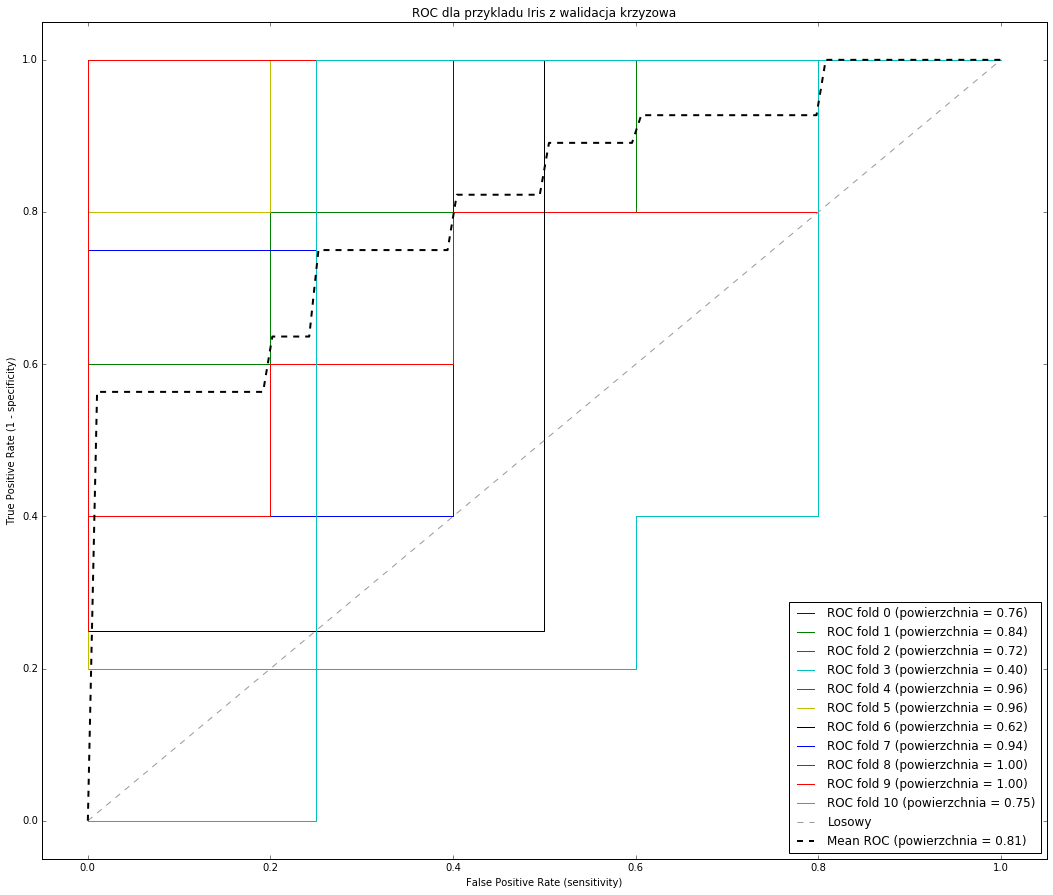

In [39]:
roc_analysis()

## F1 score
* __recall (sensitivity)__ $$recall=\frac{TP}{TP+FN}$$
  * ułamek wybranych należących do klasy (TP) i wybranych w stosunku do wszystkich z tej klasy (TP+FN)
  * klasyfikator wybiera $TP+FP$ elementów, ale spośród nich tylko $TP$ poprawnie
  * wybierając __wszystkie__ elementu maksymalizuje _recall_, ale ma niską precyzję
* __precision__ $$precision=\frac{TP}{TP+FP}$$
  * ułamek poprawnie wybranych (TP) do wszystkich wybranych (TP+FP)
  * wybierając tylko jeden element, chociaż poprawnie, klasyfikator osiąga wysoką precyzję, jednak wciąż niski recall
  
  
* __miara F__ łączy $$F=2\frac{precision\cdot recall}{precision+ recall}$$
  * równoważy precision i recall, inaczej __F1__
  * ogólniej $$F_\beta=(1+\beta^2)\frac{precision\cdot recall}{\beta^2\cdot precision+recall}$$
  
  * dla problemów wieloklasowych
    * miara F może być zastosowana do każdej z klas z osobna
    * jest też kilka metod uśredniania miedzy klasami

## Matthews corellation ceofficient
* $$MCC=\frac{TP\cdot TN-FP\cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$
  * $MCC\in[-1, 1]$
  * MCC to współczynnik korelacji między prawdziwymi i przewidzianymi klasyfikacjami
  * jest dobrą metodą przedstawienia macierzy pomyłek true/false positives/negatives w postaci jednej liczby
  * często stosowana przez biologów (ale ograniczona do problemów binarnych)

* teoria rozwinięta podczas pracy nad radarami w trakcie 2 wojny światowej
  * analiza wykrywalności obcych samolotów na ekranach radarów; szczególnie po Pearl Harbour
  * __false negative__ nie wykrycie japońskiego Zero na ekranie radaru
  * __false positive__ fałszywy alarm wykrycia, często wynik szumu